In [75]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay
import pickle

In [76]:
# Load the dataset
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

# Check shape of the dataset (rows, columns)
df.shape

(23486, 11)

In [77]:
# Display summary: columns, data types, and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


The dataset contains 23,486 rows and 11 columns.<br>
Certain columns have missing entries, whereas others are complete.<br>
There are 6 integer columns and 5 object columns.

In [78]:
# Separate column names for clarity
df.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [79]:
# Identify missing data for all columns
df.isna().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

To handle missing values effectively, we first explore the data distribution to guide our approach.

In [80]:
# Display the most frequent values for each column 
for col in df.columns:
    print(f"First values for {col}:")
    print(df[col].value_counts().head(3))
    print("-" * 35)

First values for Unnamed: 0:
Unnamed: 0
23485    1
0        1
1        1
Name: count, dtype: int64
-----------------------------------
First values for Clothing ID:
Clothing ID
1078    1024
862      806
1094     756
Name: count, dtype: int64
-----------------------------------
First values for Age:
Age
39    1269
35     909
36     842
Name: count, dtype: int64
-----------------------------------
First values for Title:
Title
Love it!     136
Beautiful     95
Love          88
Name: count, dtype: int64
-----------------------------------
First values for Review Text:
Review Text
Perfect fit and i've gotten so many compliments. i buy all my suits from here now!                                                                                                                                                                                                                                                                                                                                              

We drop rows when the target label is missing (since it does not have correct answers for the model to learn from);<br>
We replace with a placeholder if input features are missing (in order to keep more data without losing useful samples).  

In [81]:
# Drop rows where the target label is missing
df.drop(columns=['Unnamed: 0'], inplace=True)
df.dropna(subset=['Class Name'], inplace=True)

# Fill missing feature values with placeholders
df['Title'] = df['Title'].fillna("No title")
df['Review Text'] = df['Review Text'].fillna("No review")
df['Division Name'] = df['Division Name'].fillna("Unknown")
df['Department Name'] = df['Department Name'].fillna("Unknown")

In [82]:
# Check for duplicate entries
df.duplicated().sum()

np.int64(21)

The dataset contains 21 duplicate rows, which should be removed to avoid bias in the model and improve model accuracy.

In [83]:
# Remove duplicate rows 
df.drop_duplicates(inplace=True)

In [84]:
# Count of non-missing values
df.count()

Clothing ID                23451
Age                        23451
Title                      23451
Review Text                23451
Rating                     23451
Recommended IND            23451
Positive Feedback Count    23451
Division Name              23451
Department Name            23451
Class Name                 23451
dtype: int64

In [85]:
# Show top rows to inspect data
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,No title,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,No title,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [86]:
# Show the last few rows of the dataset
df.tail()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses
23485,1104,52,Please make more like this one!,This dress in a lovely platinum is feminine an...,5,1,22,General Petite,Dresses,Dresses


In the text data, we normalize only the 'Review Text' column because it contains unstructured information.<br>
Lowercasing (1), removing punctuation (2), and removing stopwords (3) help reduce noise and improve model performance.<br>
Other columns are short labels or categories that do not require full text normalization.<br>

1. **Lowercasing** - avoids treating the same word differently due to capitalization.
2. **Removing punctuation** - eliminates irrelevant symbols.
3. **Removing stopwords** - filters out common words that add noise.

In [87]:
# Lowercase all words in 'Review Text'   
df['Review Text'] = df['Review Text'].str.lower()  

# Remove punctuation and extra spaces from 'Review Text'   
df['Review Text'] = df['Review Text'].str.replace(r'\s+', ' ', regex=True).str.strip() 

In [88]:
# Convert text to numeric features using TF-IDF, removing stopwords, and keep the top 5000 features 
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000) 
X_text = vectorizer.fit_transform(df['Review Text'])

In [89]:
# Show first rows of the normalized column
df['Review Text'].head()

0    absolutely wonderful - silky and sexy and comf...
1    love this dress! it's sooo pretty. i happened ...
2    i had such high hopes for this dress and reall...
3    i love, love, love this jumpsuit. it's fun, fl...
4    this shirt is very flattering to all due to th...
Name: Review Text, dtype: object

In [90]:
# Check statistics of numeric columns
df.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23451.000000,23451.000000,23451.000000,23451.000000,23451.000000
mean,918.465097,43.202294,4.194874,0.822097,2.539423
std,202.790476,12.282083,1.110436,0.382439,5.705645
min,0.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


After checking the statistics, we see that numeric values have consistent ranges and do not require normalization.

In [91]:
# Display column data types
df.dtypes

Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

Since we have categorical columns (text labels), we must convert it to numbers so the model can recognize patterns and make predictions.<br>
**Label Encoding** - for target labels (single column prediction).<br>
**One-Hot Encoding** - for categorical features (no implied order).

In [92]:
# Encode the target label 'Class Name' into numeric values
le = LabelEncoder()
df['Class Name'] = le.fit_transform(df['Class Name'])  

# One-Hot Encode 'Division Name' and 'Department Name' categorical features
df = pd.get_dummies(df, columns=['Division Name', 'Department Name'])

Now let’s explore some additional statistics and relationships in the dataset.

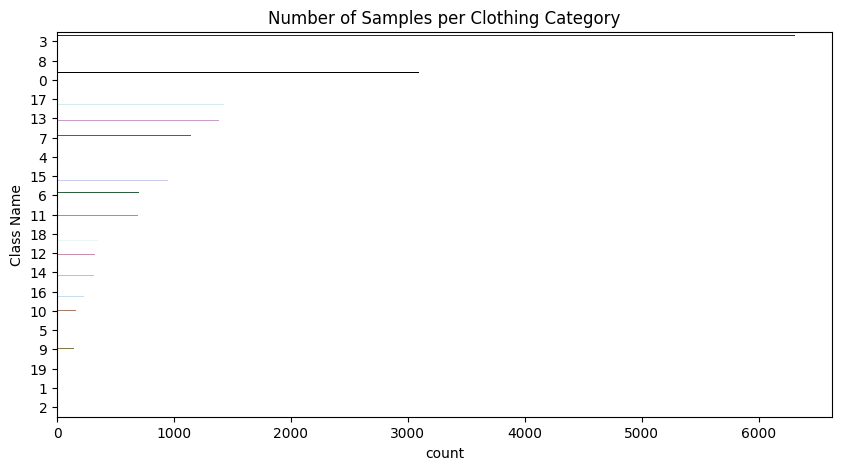

In [93]:
# Create a horizontal bar chart showing the number of samples per clothing category
plt.figure(figsize=(10,5))
sns.countplot(y="Class Name", data=df, order=df['Class Name'].value_counts().index, palette="cubehelix", hue=y, legend=False)
plt.title("Number of Samples per Clothing Category")
plt.show()

In [94]:
# Show mapping of encoded labels back to original clothing names
for code, name in zip(le.transform(le.classes_), le.classes_):
    print(f"{code} → {name}")

0 → Blouses
1 → Casual bottoms
2 → Chemises
3 → Dresses
4 → Fine gauge
5 → Intimates
6 → Jackets
7 → Jeans
8 → Knits
9 → Layering
10 → Legwear
11 → Lounge
12 → Outerwear
13 → Pants
14 → Shorts
15 → Skirts
16 → Sleep
17 → Sweaters
18 → Swim
19 → Trend


We can see that the top three categories with the most samples are **Dresses**, **Blouses**, and **Knits**.

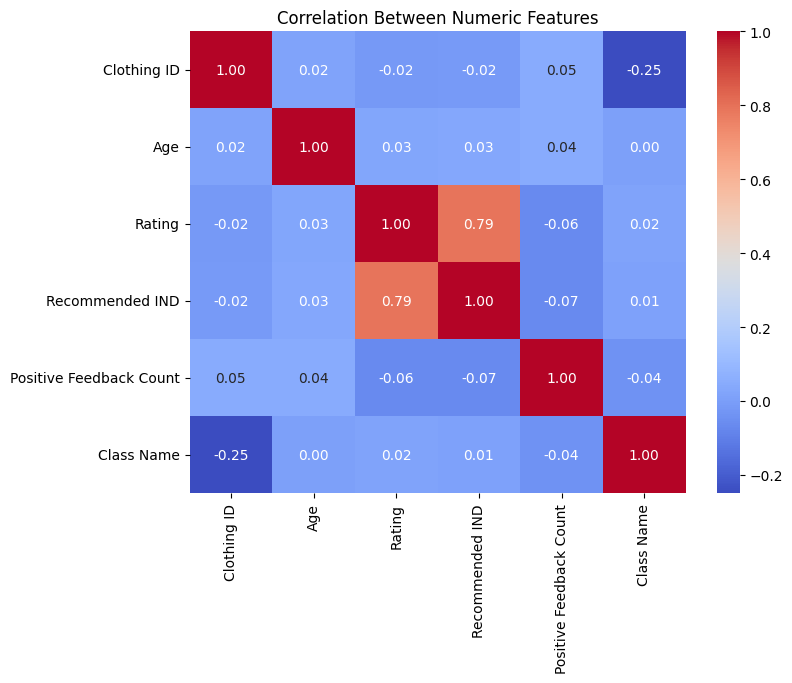

In [95]:
# Correlation heatmap for numeric features
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Numeric Features")
plt.show()

Most features are independent, with correlations near zero. The strongest link (0.79) is between Rating and Recommended IND, meaning higher ratings usually lead to more recommendations. A small negative correlation (-0.25) exists between Clothing ID and Class Name, but it’s weak.

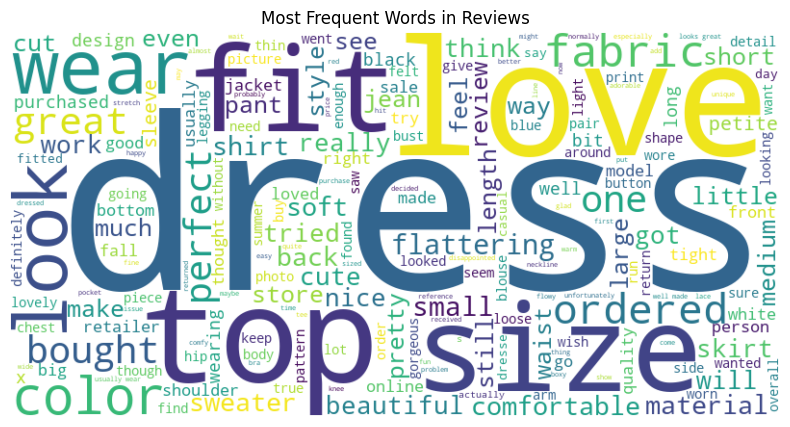

In [96]:
# Most frequent words mentioned in reviews 
all_words_text = " ".join(df['Review Text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_words_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Reviews")
plt.show()

In [99]:
# Features and target labels
X = df['Review Text']  
y = df['Class Name']   

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Train size: (17587,)
Test size: (5863,)


In [100]:
# Check class distribution
print("y_train:", Counter(y_train))
print("y_test:", Counter(y_test))

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

y_train: Counter({3: 4734, 8: 3626, 0: 2320, 17: 1071, 13: 1041, 7: 859, 4: 824, 15: 709, 6: 528, 11: 518, 18: 262, 12: 246, 14: 238, 16: 171, 10: 124, 5: 115, 9: 110, 19: 89, 1: 2})
y_test: Counter({3: 1578, 8: 1209, 0: 773, 17: 357, 13: 347, 7: 287, 4: 275, 15: 236, 6: 176, 11: 173, 18: 88, 12: 82, 14: 79, 16: 57, 10: 41, 5: 39, 9: 36, 19: 30})


In [101]:
# Initialize first model (Logistic Regression) with balanced class weights
first_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Train the model
first_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred_first_model = first_model.predict(X_test_tfidf)

# Evaluate the performance
print("First Model (Logistic Regression) Accuracy:", accuracy_score(y_test, y_pred_first_model))
print(classification_report(y_test, y_pred_first_model, zero_division=0))

First Model (Logistic Regression) Accuracy: 0.5795667746887259
              precision    recall  f1-score   support

           0       0.50      0.52      0.51       773
           1       0.00      0.00      0.00         0
           3       0.92      0.77      0.84      1578
           4       0.33      0.34      0.33       275
           5       0.28      0.62      0.39        39
           6       0.47      0.66      0.55       176
           7       0.70      0.74      0.72       287
           8       0.63      0.41      0.49      1209
           9       0.13      0.31      0.18        36
          10       0.40      0.56      0.46        41
          11       0.17      0.23      0.19       173
          12       0.46      0.56      0.50        82
          13       0.55      0.64      0.60       347
          14       0.49      0.68      0.57        79
          15       0.73      0.83      0.78       236
          16       0.21      0.32      0.25        57
          17      

The Logistic Regression model achieved an accuracy of about 58%, meaning it correctly predicted roughly six out of ten samples. Overall, the performance is moderate, with a weighted average F1-score around 0.60.

Some classes were predicted very well — for example, classes 3, 7, 15, and 18 show high precision and recall, meaning the model consistently recognizes them correctly. On the other hand, classes like 5, 9, 16, and 19 performed poorly, often being missed entirely. This is likely due to the fact that these classes have very few examples in the dataset, which makes them harder for the model to learn.

In [102]:
# Initialize second model (Naive Bayes) with smoothing
second_model = MultinomialNB(alpha=0.1)  # alpha smoothing helps generalize better

# Train the model
second_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred_second_model = second_model.predict(X_test_tfidf)

# Evaluate performance
print("Second Model (Naive Bayes) Accuracy:", accuracy_score(y_test, y_pred_second_model))
print(classification_report(y_test, y_pred_second_model, zero_division=0))

Second Model (Naive Bayes) Accuracy: 0.549718574108818
              precision    recall  f1-score   support

           0       0.52      0.31      0.39       773
           3       0.61      0.91      0.73      1578
           4       0.46      0.09      0.15       275
           5       0.50      0.03      0.05        39
           6       0.74      0.15      0.25       176
           7       0.76      0.68      0.72       287
           8       0.43      0.73      0.54      1209
           9       0.00      0.00      0.00        36
          10       1.00      0.07      0.14        41
          11       0.52      0.08      0.14       173
          12       0.78      0.09      0.15        82
          13       0.64      0.40      0.49       347
          14       0.62      0.06      0.11        79
          15       0.92      0.32      0.48       236
          16       1.00      0.02      0.03        57
          17       0.60      0.37      0.46       357
          18       0.95   

The Naive Bayes model achieved an accuracy of about 55%, which is considerably lower than Logistic Regression. The model performed reasonably well for a few classes with many samples, such as Dresses and Knits, where recall was relatively high. However, for most other classes — especially those with fewer examples — performance was very poor. Many classes had precision and recall close to zero, meaning the model rarely predicted them correctly at all.

This suggests that Naive Bayes struggled with the complexity and imbalance of the dataset. It tends to favor larger classes and fails to capture subtle distinctions between categories. 

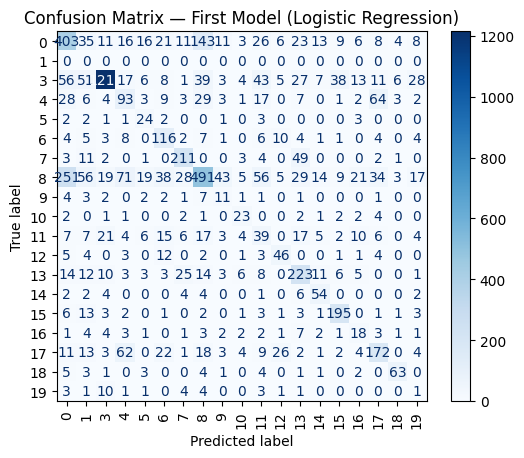

In [103]:
# Confusion matrix for the Logistic Regression model
ConfusionMatrixDisplay.from_estimator(
    first_model, 
    X_test_tfidf, 
    y_test,
    cmap=plt.cm.Blues,
    xticks_rotation='vertical'
)

plt.title("Confusion Matrix — First Model (Logistic Regression)")
plt.show()

The confusion matrix confirms what we discussed earlier - Logistic Regression handles the larger, more distinct classes well but struggles with smaller or more ambiguous ones. This highlights the impact of class imbalance on performance. To address this, we could try techniques like oversampling the smaller classes, undersampling the larger ones, or using class-weighted models. Alternatively, working with a smaller, more balanced dataset could also help improve predictions.

In [105]:
# Function to predict category for a given sentence
def predict_category(text, model, vectorizer, label_encoder):
    text_tfidf = vectorizer.transform([text])
    pred_label = model.predict(text_tfidf)[0]
    category = label_encoder.inverse_transform([pred_label])[0]
    return category

# Example
user_input = "This dress fits perfectly and looks elegant."
print("Predicted category:", predict_category(user_input, first_model, vectorizer, le))

Predicted category: Dresses


In [106]:
# Save the TF-IDF vectorizer so we can use it later without retraining
pickle.dump(vectorizer, open("vectorizer.pkl", "wb"))

# Save the trained Logistic Regression model for future predictions
pickle.dump(first_model, open("first_model.pkl", "wb"))

# Save the label encoder to translate labels back to their original form
pickle.dump(le, open("label_encoder.pkl", "wb"))